In [1]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests
import json
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model, preprocess = clip.load("ViT-B/16", device=device)

In [3]:
DATASET_DIRECTORY = "D:\Datasets\Amazon\Amazon Product Dataset"
sample_data_path = 'D:\Datasets\Amazon\Amazon Product Dataset\meta_Gift_Cards.jsonl'

In [106]:
def image_url_to_img(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    # plt.imshow(img)
    # plt.show()
    return img

## Text and Image Embedding Functions

In [43]:
def generate_text_embeddings(text):
    text_features = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_embeddings = model.encode_text(text_features)
        text_embeddings /= text_embeddings.norm(dim = -1, keepdim= True)
        return text_embeddings.cpu().numpy()[0]

def generate_image_embeddings(img):
    img_preprocessed = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embeddings = model.encode_image(img_preprocessed).float()
        image_embeddings /= image_embeddings.norm(dim = -1, keepdim = True)
    return image_embeddings[0].cpu().numpy()


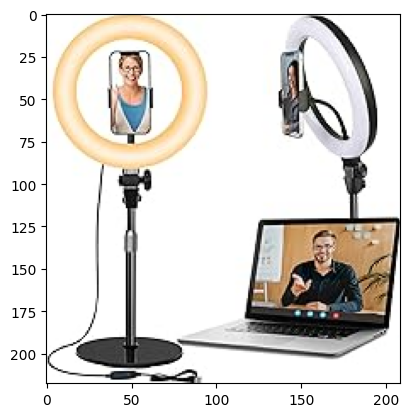

[ 1.81967020e-02 -3.43575478e-02 -9.65717062e-03 -1.70175001e-04
  6.26261439e-03  3.23958956e-02 -1.32600050e-02  6.24430664e-02
  3.38591300e-02 -1.90788265e-02 -4.27383278e-03 -1.64923836e-02
  2.61867307e-02  1.39366630e-02  1.33891981e-02 -3.03883236e-02
 -3.05919852e-02 -2.38120854e-02  1.23572433e-02 -7.12215854e-03
  1.10380752e-02 -2.33352501e-02 -1.90107878e-02  2.17767549e-03
 -1.30933532e-02 -2.80025341e-02 -2.76475120e-02  1.42590534e-02
  3.83928902e-02 -3.77743840e-02 -8.87990557e-03 -3.91019173e-02
 -1.69938933e-02 -4.22108471e-02 -8.15232769e-02  1.90708674e-02
 -9.31629352e-03 -2.34180503e-02 -1.09420726e-02  1.92880500e-02
 -1.50792571e-02  1.64283551e-02  1.30419405e-02 -3.98569100e-04
 -3.40340957e-02 -5.54103777e-02 -2.47681104e-02  8.58621672e-03
 -2.28989348e-02 -3.49576958e-02  6.07655607e-02 -1.01154055e-02
  3.24087515e-02  2.25640908e-02 -4.44682017e-02  1.39902895e-02
  2.04804409e-02  6.25826651e-03  1.52479587e-02 -8.34505036e-02
 -8.22826847e-02  1.60431

In [15]:
img = image_url_to_img('https://m.media-amazon.com/images/I/612JNfob9nL._AC_UY218_.jpg')
embed = generate_image_embeddings(img)
print(embed)
# print(list(img.getdata()))

In [25]:
def extract_img_urls(image_array):
    urls = []
    for item in image_array:
        # print(item)
        if item['hi_res']:
            urls.append(item['hi_res'])
        elif item['large']:
            urls.append(item['large'])
    return urls

In [26]:
text_embeddings = []
with open(sample_data_path) as file:
    for line in file:
        data = json.loads(line.strip())
        # print(data)
        # print(data['images'])
        urls = extract_img_urls(data['images'])
        print(urls)
        # print(product['Reviews'])
        # image_embedding = generate_image_embeddings(product['Image'])
        # print(image_embedding)
        # title = product['Title']
        # title_embeddings = generate_text_embeddings(title)
        # text_embeddings.append(title_embeddings)

['https://m.media-amazon.com/images/I/71cWJvVGYtL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/71q-qp4b3-L._SL1500_.jpg', 'https://m.media-amazon.com/images/I/71KutAnl9gL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/61FMUKaXfJL._SL1175_.jpg', 'https://m.media-amazon.com/images/I/61blLcj3pWL._SL1500_.jpg']
['https://m.media-amazon.com/images/I/51PBGo9pQvL.jpg', 'https://m.media-amazon.com/images/I/51g8xw90yeL.jpg']
['https://m.media-amazon.com/images/I/51Nu3xiHuUL.jpg']
['https://m.media-amazon.com/images/I/61Dq0CdBIuL._SL1500_.jpg']
['https://m.media-amazon.com/images/I/81B3hOC7r-L._SL1500_.jpg', 'https://m.media-amazon.com/images/I/91MrLovuFrL._SL1500_.jpg']
['https://m.media-amazon.com/images/I/71tuXbbE0TL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/71Nqlm+ZyqL._SL1236_.jpg', 'https://m.media-amazon.com/images/I/61zH0ujIxRL._SL1229_.jpg', 'https://m.media-amazon.com/images/I/81J+vQ-3-zL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/71Dbc6HAYUL._SL1500_.jpg

In [29]:
from pymilvus import (
    connections,
    utility,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    db
)

In [30]:
client = connections.connect("default", host="localhost", port="19530")

In [98]:
db.list_database()

['default', 'Products']

In [101]:
# d = {
#     "main_category": "All Beauty", 
#      "title": "Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)", 
#      "average_rating": 4.8, 
#      "rating_number": 10, 
#      "features": [], 
#      "description": [], 
#      "price": null, 
#      "images": [{"thumb": "https://m.media-amazon.com/images/I/41qfjSfqNyL._SS40_.jpg", "large": "https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg", "variant": "MAIN", "hi_res": null}, {"thumb": "https://m.media-amazon.com/images/I/41w2yznfuZL._SS40_.jpg", "large": "https://m.media-amazon.com/images/I/41w2yznfuZL.jpg", "variant": "PT01", "hi_res": "https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg"}], 
#      "videos": [], 
#      "store": "Howard Products", 
#      "categories": [], 
#      "details": {"Package Dimensions": "7.1 x 5.5 x 3 inches; 2.38 Pounds", "UPC": "617390882781"}, 
#      "parent_asin": "B01CUPMQZE", 
#      "bought_together": null
#      }
# Defining schema
fields = [
    FieldSchema(name="product_id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="title_vector", dtype=DataType.FLOAT_VECTOR, dim=512),  
    FieldSchema(name="title", dtype=DataType.VARCHAR, max_length = 500),
    FieldSchema(name="average_rating", dtype=DataType.FLOAT),
    FieldSchema(name="features", dtype=DataType.ARRAY, max_capacity = 100, element_type = DataType.VARCHAR, max_length = 1000),
    FieldSchema(name="description", dtype=DataType.ARRAY, max_capacity = 50, element_type = DataType.VARCHAR, max_length = 5000),
    FieldSchema(name="categories", dtype=DataType.ARRAY, max_capacity = 50, element_type = DataType.VARCHAR, max_length = 100),
    FieldSchema(name="price", dtype=DataType.FLOAT),
    FieldSchema(name="store", dtype=DataType.VARCHAR, max_length = 100),
    FieldSchema(name="main_category", dtype=DataType.VARCHAR, max_length = 50)
]

fields_images = [
    FieldSchema(name="image_id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="p_id", dtype=DataType.INT64),  # Foreign key to Products
    FieldSchema(name="image_vector", dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name="image_url", dtype=DataType.VARCHAR, max_length=5000)
]


In [100]:
utility.drop_collection('images')

In [102]:
# collection_name = 'product_collection'
product_schema = CollectionSchema(fields, description="Products collection")
products_collection = Collection(name = 'products', schema=product_schema)

In [103]:
image_schema = CollectionSchema(fields_images, description='Images Collection')
images_collection = Collection(name = 'images', schema = image_schema)

In [107]:
# index_params = {
#     "field_name":"product_id",
#     "index_type":"", 
#     "index_name": "product_id_index" 
# }
# products_collection.create_index(
#   collection_name="products", # Specify the collection name
#   index_params=index_params
# )

index_params = {
    "metric_type": "COSINE",
    "index_type": "IVF_FLAT",
    "params": {"nlist": 128}
}

products_collection.create_index(field_name="title_vector", index_params = index_params)
products_collection.load()

images_collection.create_index(field_name="image_vector", index_params = index_params)
images_collection.load()

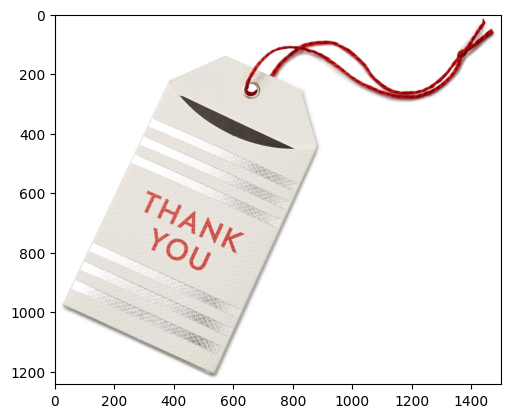

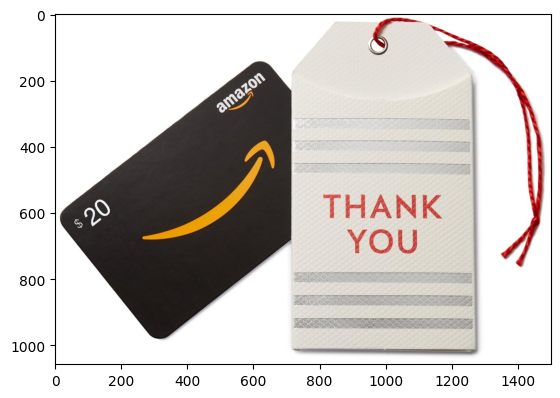

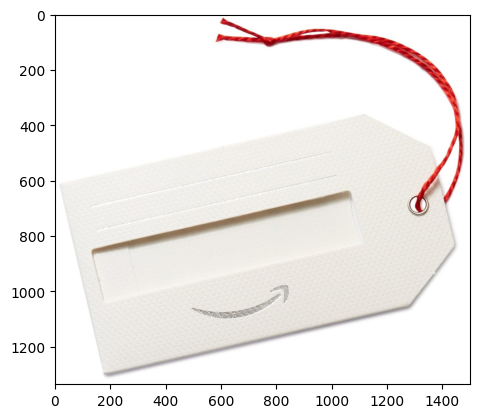

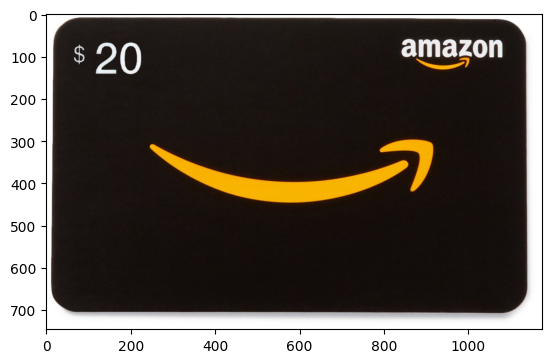

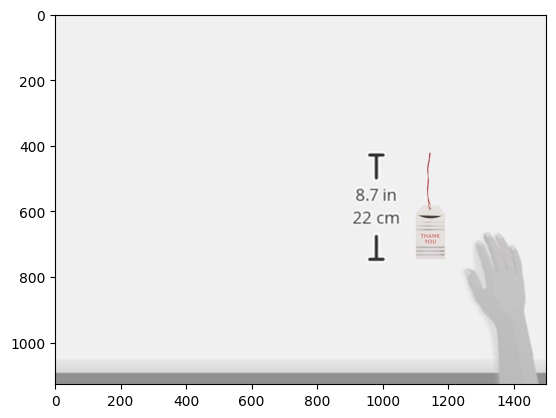

Inserted product ID: 450845723981535208 with 5 images


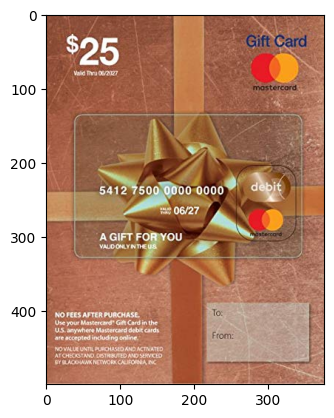

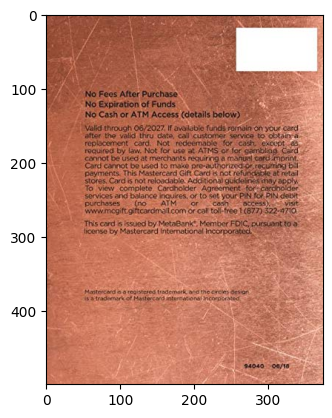

Inserted product ID: 450845723981535220 with 2 images


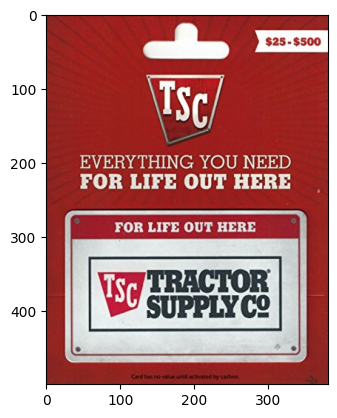

Inserted product ID: 450845723981535226 with 1 images


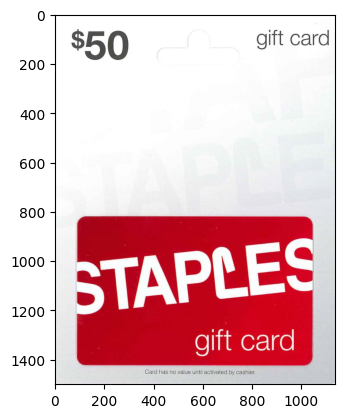

Inserted product ID: 450845723981535230 with 1 images


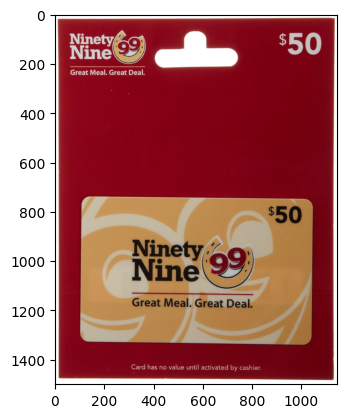

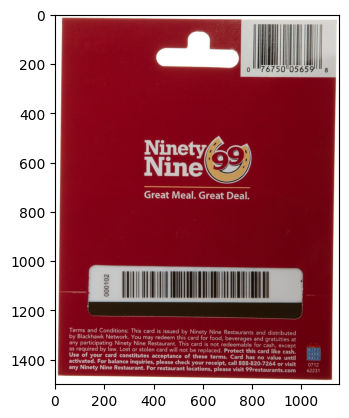

Inserted product ID: 450845723981535234 with 2 images


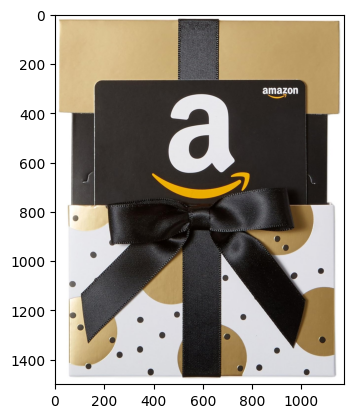

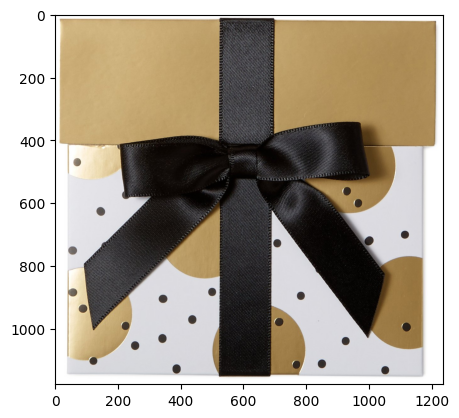

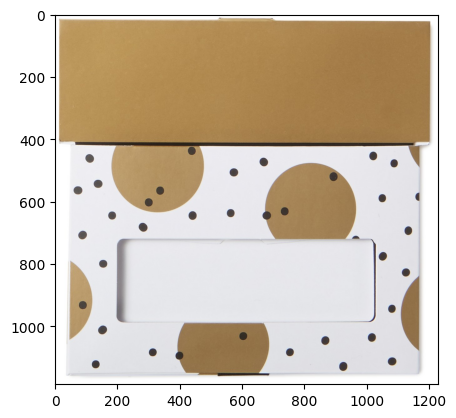

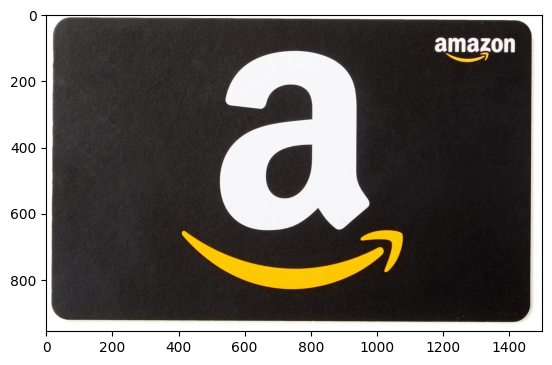

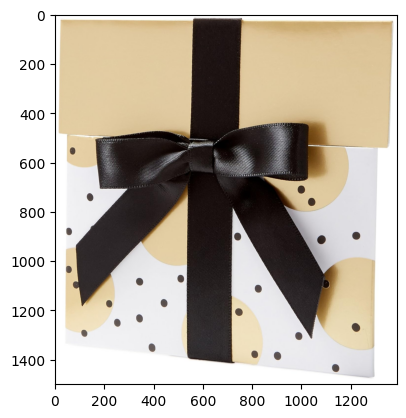

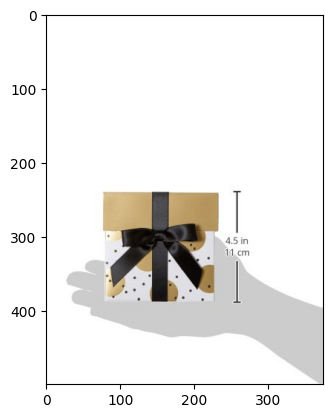

Inserted product ID: 450845723981535240 with 6 images


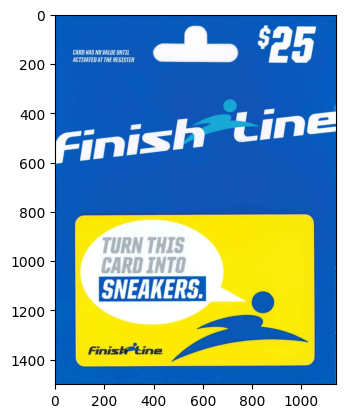

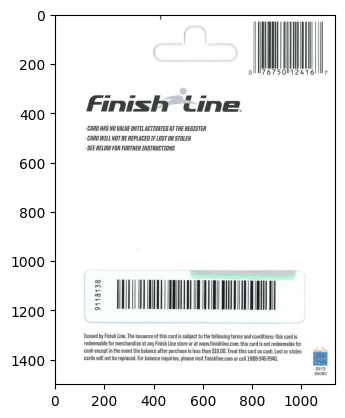

Inserted product ID: 450845723981535254 with 2 images


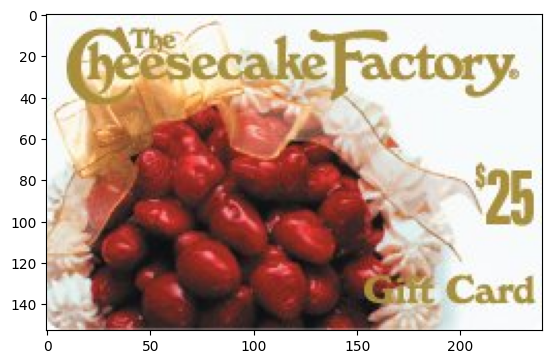

Inserted product ID: 450845723981535260 with 1 images


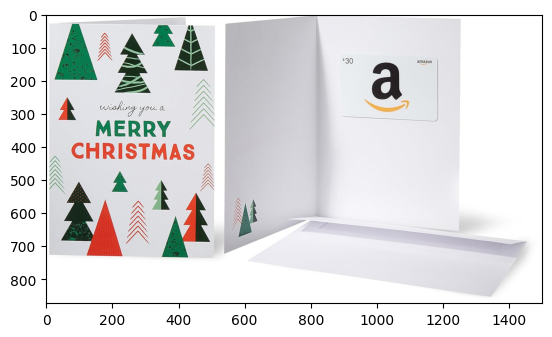

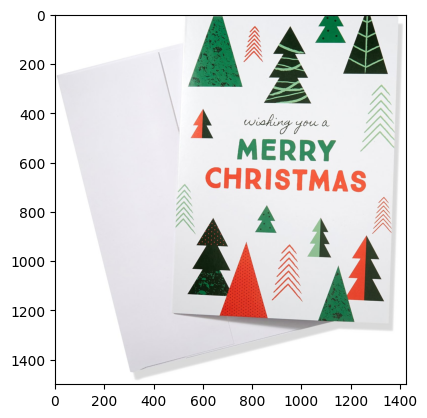

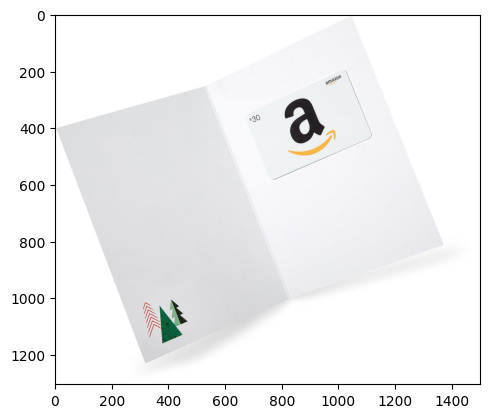

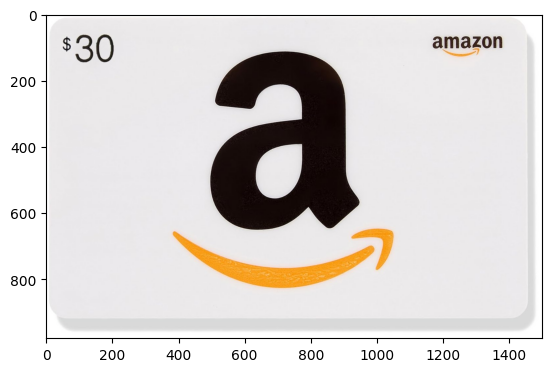

Inserted product ID: 450845723981535264 with 4 images


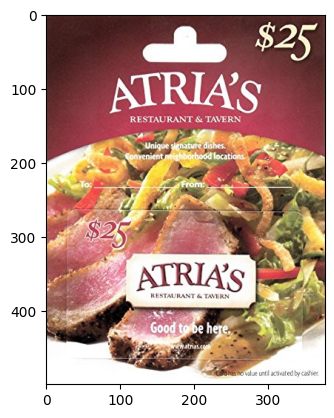

Inserted product ID: 450845723981535274 with 1 images


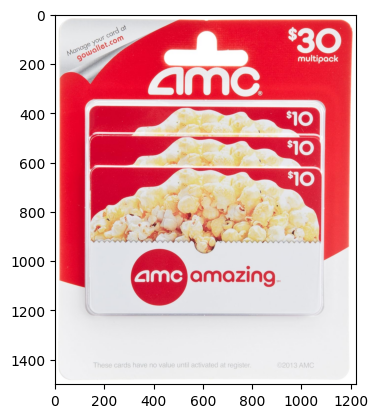

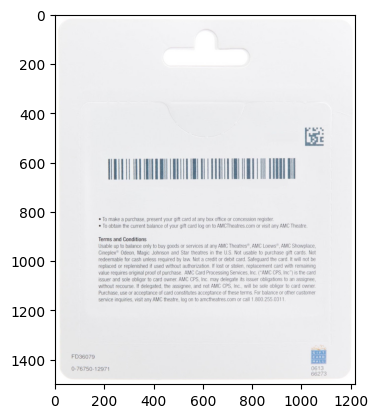

Inserted product ID: 450845723981535278 with 2 images


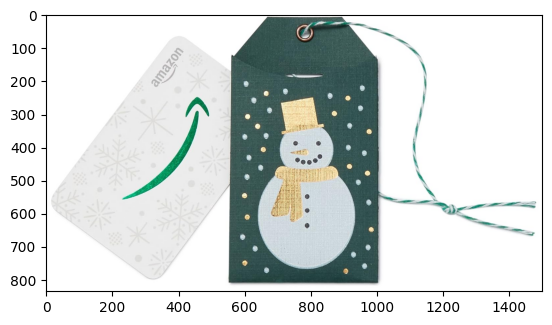

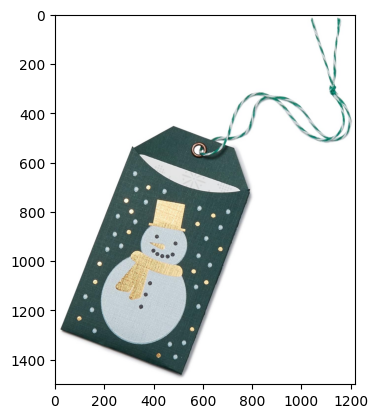

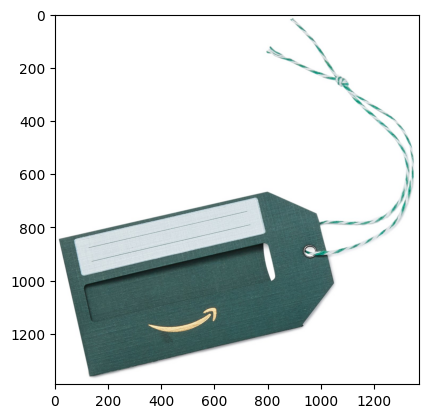

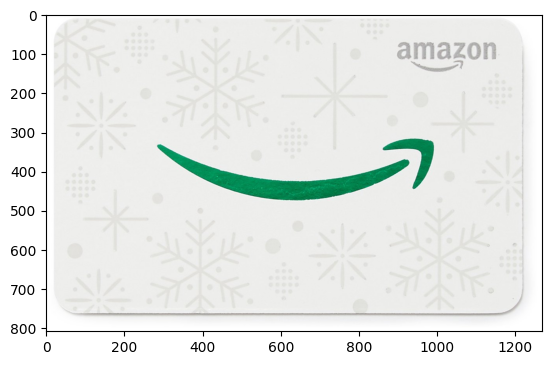

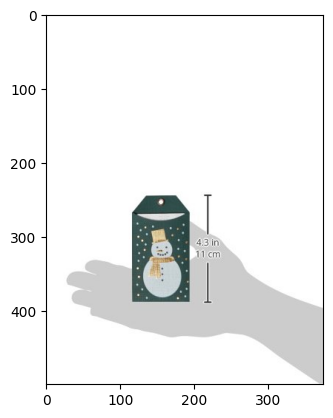

Inserted product ID: 450845723981535284 with 5 images


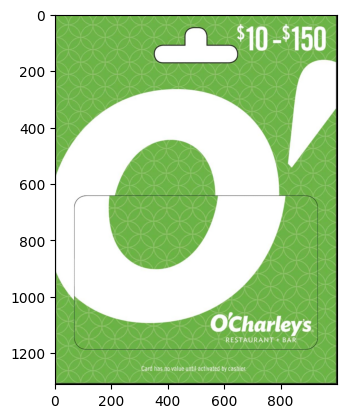

Inserted product ID: 450845723981535296 with 1 images


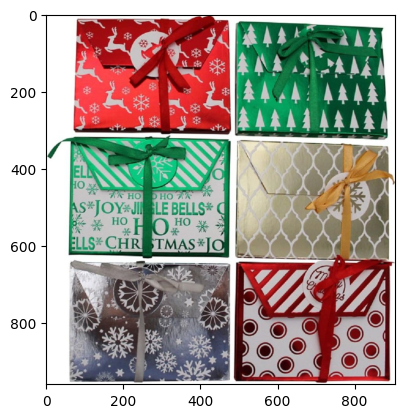

Inserted product ID: 450845723981535300 with 1 images


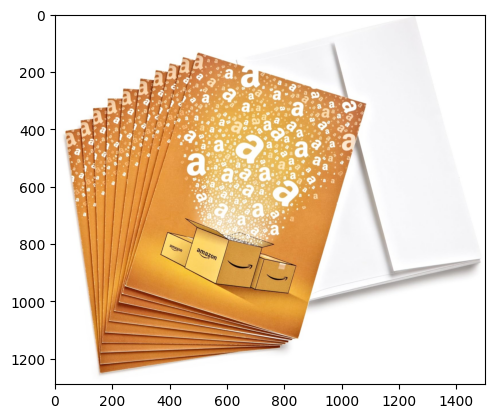

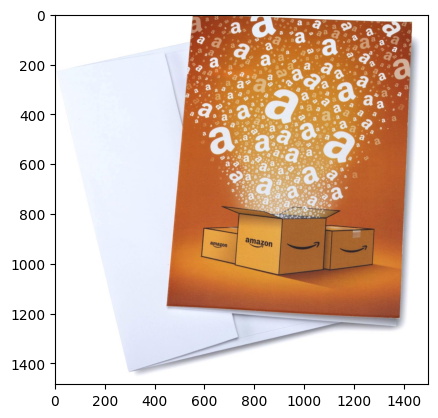

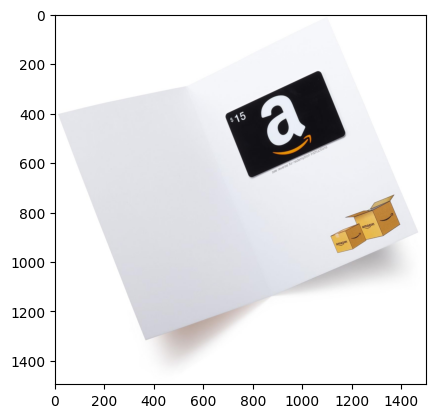

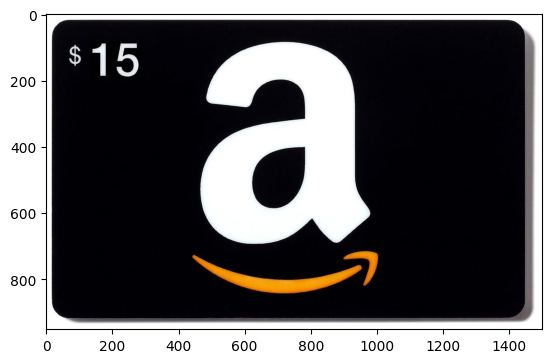

Inserted product ID: 450845723981535304 with 4 images


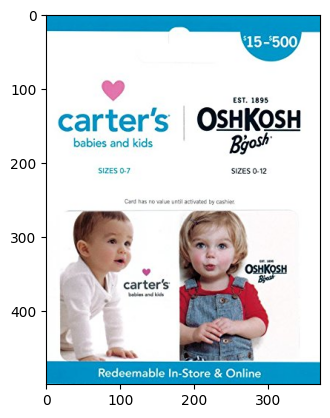

Inserted product ID: 450845723981535314 with 1 images


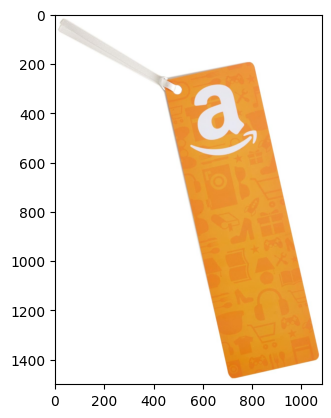

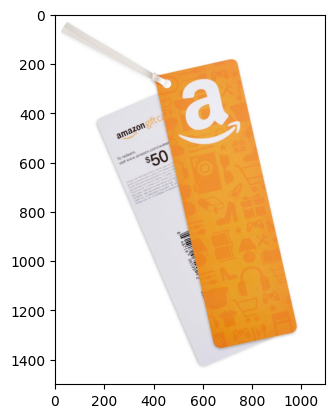

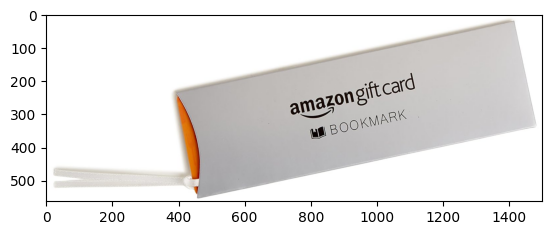

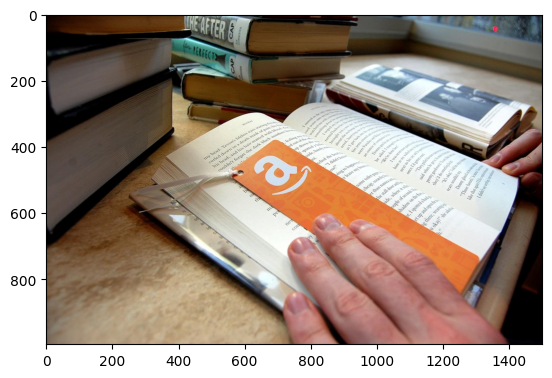

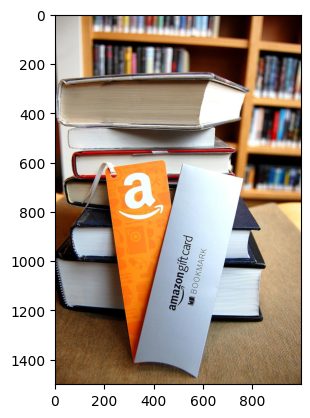

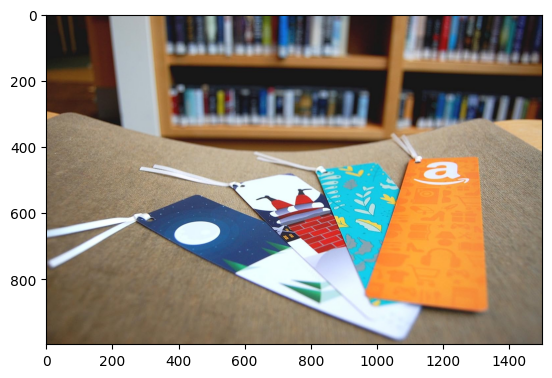

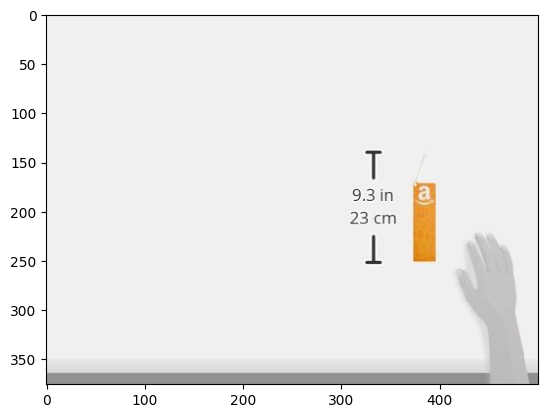

Inserted product ID: 450845723981535318 with 7 images


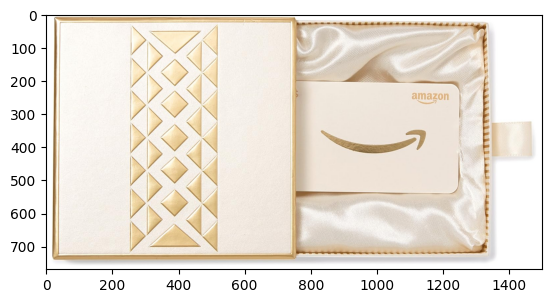

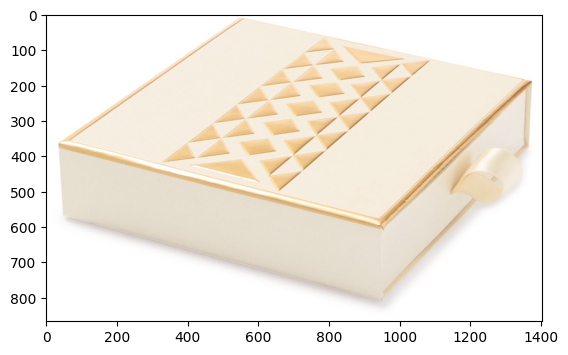

ConnectTimeout: HTTPSConnectionPool(host='m.media-amazon.com', port=443): Max retries exceeded with url: /images/I/61y69i5ZCTL._SL1500_.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001A731E8DA50>, 'Connection to m.media-amazon.com timed out. (connect timeout=None)'))

In [105]:
with open(sample_data_path) as file:
    for line in file:
        data = json.loads(line.strip())
        
        # Generate title embedding
        title_embedding = generate_text_embeddings(data['title'])
        
        # Extract product information
        title = data['title']
        average_rating = data['average_rating']
        features = data['features']
        description = data['description']
        categories = data['categories']
        price = data['price']
        if not price:
            price = 0.0
        main_category = data['main_category']
        store = data['store']
        
        
        # Prepare product data
        product_data = {
            'title_vector': title_embedding.tolist(),
            'title': title,
            'average_rating': average_rating,
            'features': features,
            'description': description,
            'categories': categories,
            'price': price,
            'store': store,
            'main_category': main_category,
        }
        
        # Insert product data into the products collection
        products_collection.insert([product_data])
        # Flush to ensure data is written
        products_collection.flush()
        
        # Retrieve product ID
        product_ids = products_collection.query(expr=f'title == "{title}"', output_fields=["product_id"])
        product_id = product_ids[0]["product_id"]
        
        # Extract and process image URLs
        image_urls = extract_img_urls(data['images'])
        image_embeddings = []
        for url in image_urls:
            img = image_url_to_img(url)
            image_embedding = generate_image_embeddings(img)
            image_embeddings.append((image_embedding, url))
        
        # Insert each image embedding with the associated product ID
        for image_embedding, image_url in image_embeddings:
            image_data = {
                'p_id': product_id,
                'image_vector': image_embedding.tolist(),
                'image_url': image_url,
            }
            images_collection.insert([image_data])
        
        # Flush to ensure data is written
        images_collection.flush()
        
        print(f"Inserted product ID: {product_id} with {len(image_embeddings)} images")

In [97]:
title = "Atria's Restaurant & Tavern Gift Card"
product_ids = products_collection.query(expr=f'title == "{title}"', output_fields=["product_id"])
product_id = product_ids[0]["product_id"]
product_id

450845723981535206

In [ ]:
status, ids = collection.insert([entity])


In [68]:
# collection.drop_index(index_name = 'title_vector')

In [69]:
index_params = {
    "metric_type": "COSINE",
    "index_type": "IVF_FLAT",
    "params": {"nlist": 128}
}

In [70]:
collection.create_index(field_name="title_vector", index_params= index_params)
collection.create_index(field_name = "image_vector", index_params = index_params)

Status(code=0, message=)

In [71]:
collection.load()

In [72]:
search_params = {
    "metric_type": "COSINE", 
    "offset": 0, 
    "ignore_growing": False, 
    "params": {"nprobe": 10}
}

In [130]:
# sample_query = products[1]['Title']
sample_query = products[1]['Image']
# sample_query_embedding = generate_text_embeddings(sample_query)
sample_query_embedding = generate_image_embeddings(sample_query)
sample_query_embedding

array([-7.11805940e-01, -4.88294363e-02,  3.30361724e-01,  2.18768850e-01,
        1.27947137e-01,  1.02498323e-01,  1.86483592e-01,  6.57398775e-02,
        1.82011008e-01,  1.76132232e-01,  3.03569198e-01, -5.66980481e-01,
       -1.45702362e-01, -6.45787418e-02,  2.16639698e-01,  1.31733939e-01,
       -6.89856231e-01, -1.97257280e-01, -1.79133296e-01,  8.63223076e-02,
       -6.48642004e-01, -2.63700396e-01,  2.93147087e-01,  4.38241363e-02,
        8.10087621e-02,  2.22875297e-01, -3.14478755e-01,  3.99146676e-01,
        4.84298170e-03,  3.14859897e-01,  1.40053779e-02, -3.39155197e-01,
        1.23245724e-01, -3.54683131e-01, -3.18638176e-01, -6.34527922e-01,
       -2.28771135e-01,  2.39075616e-01, -6.80975020e-02,  8.76162291e-01,
        1.57782972e-01,  1.91779166e-01,  2.00409859e-01,  5.16777217e-01,
        2.45569929e-01, -5.45612693e-01, -8.59006941e-02,  2.32251883e-02,
        4.35072601e-01,  4.87945974e-04,  1.95686996e-01, -2.96398550e-01,
        4.53765631e-01,  

In [131]:
sample_query

'https://m.media-amazon.com/images/I/81sv3I05wCL._AC_UL320_.jpg'

In [132]:
results = collection.search(
    data=[sample_query_embedding], 
    anns_field="image_vector", 
    # the sum of `offset` in `param` and `limit` 
    # should be less than 16384.
    param=search_params,
    limit=10,
    expr=None,
    # set the names of the fields you want to 
    # retrieve from the search result.
    output_fields=['title','price'],
    consistency_level="Strong"
)


In [84]:
results[0].ids

[450687289225645638,
 450687289225645662,
 450687289225645648,
 450687289225645646,
 450687289225645666,
 450687289225645664,
 450687289225645674,
 450687289225645644,
 450687289225645654,
 450687289225645676]

In [85]:
results[0].distances

[1.0000001192092896,
 0.5990191698074341,
 0.5963578224182129,
 0.5753413438796997,
 0.5619478225708008,
 0.5553554892539978,
 0.5465940237045288,
 0.538995087146759,
 0.5369709730148315,
 0.520717442035675]

In [133]:
hit = results[0][0]
hit.entity.get('title')

'Play Purse for Little Girls, 35PCS Toddler Purse with Pretend Makeup for Toddlers, Princess Toys Includes Handbag, Phone, Wallet, Camera, Keys, Kids Purse Birthday Gift for Girls Age 3 4 5 6+'

In [134]:
for result in results[0]:
    # print(result[0].entity.get('title'),'\n')
    print(result.entity)

id: 450687289225645640, distance: 0.9999998807907104, entity: {'title': 'Play Purse for Little Girls, 35PCS Toddler Purse with Pretend Makeup for Toddlers, Princess Toys Includes Handbag, Phone, Wallet, Camera, Keys, Kids Purse Birthday Gift for Girls Age 3 4 5 6+', 'price': '$17.99'}
id: 450687289225645650, distance: 0.6877689957618713, entity: {'title': 'Kids Smart Phone for Girls, Christmas Birthday Gifts for Girls Age 3-10 Kids Toys Cell Phone, 2.8" Touchscreen Toddler Learning Play Toy Phone with Dual Camera, Game, Music Player, 8G SD Card (Purple)', 'price': '$35.90'}
id: 450687289225645664, distance: 0.6292790174484253, entity: {'title': 'Fidget Toys, 120 Pack Fidgets Set Stocking Stuffers for Kids Party Favors Autism Sensory Toy Bulk Adults Kids Boys Girls Teens Stress Autistic ADHD Anxiety Carnival Treasure Classroom Prizes', 'price': '$14.99'}
id: 450687289225645658, distance: 0.6275117993354797, entity: {'title': 'Sloosh Bubble Lawn Mower Toddler Toys - Kids Toys Bubble Mach